In [7]:
%load_ext autoreload
%autoreload 2
import sys
import helper_methods as hm
import footprint_primitives as fp
import plotting
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage import exposure
import polygon_primitives as pp
import geopandas

import os
import polygon_extraction.json_parser as jp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def plot_line_segments_on_grid(grid, line_segments, thresh=0.0):
    if thresh > 0.0:
        image = grid.get_thresholded_counts(thresh)
    else:
        image = grid.log_transform_counts_image()
        
    transformed_line_segments = []
    for each in line_segments:
        transformed_line_segments.append(grid.transform_line_to_grid_space(each))
    plotting.draw_boundaries(image, transformed_line_segments)

minimum_wall_height = 2.0
minimum_wall_length = 2.0
filename = "../LAS/alameda8processed.las"
points = hm.get_points_from_file(filename)
# points = hm.project_points(points)
points, offset = hm.subtract_point_mean(points)
display_grid = fp.Grid(points)

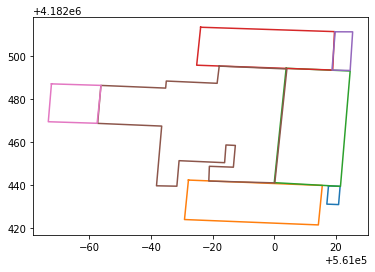

In [10]:
file_name = "polygon_extraction/merged2.json"
polygon_coords, heights, polygons = jp.parse_json_file(file_name)

for polygon in polygons:
    x,y = polygon.exterior.xy
    plt.plot(x,y);

# xy_offset = np.array([offset[0], offset[1]])
# polygons = [polygons[3]]
# all_edges = []
# for polygon in polygons:
#     polygon.offset_polygon(xy_offset)
#     all_edges = all_edges + polygon.get_edges()
# plot_line_segments_on_grid(display_grid, all_edges)


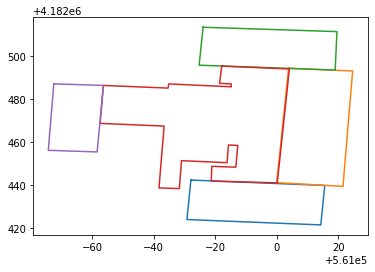

In [12]:
comp_file_name = "polygon_extraction/merged_alameda8.json"
polygon_coords, heights, ref_polygons = jp.parse_json_file(comp_file_name)

for polygon in ref_polygons:
    x,y = polygon.exterior.xy
    plt.plot(x,y);

In [13]:
poly_series = geopandas.GeoSeries(polygons)
ref_series = geopandas.GeoSeries(ref_polygons)

poly_frame = geopandas.GeoDataFrame({'geometry': poly_series})
ref_frame = geopandas.GeoDataFrame({'geometry': ref_series})

5184.330648357353
[0.0, 0.0]


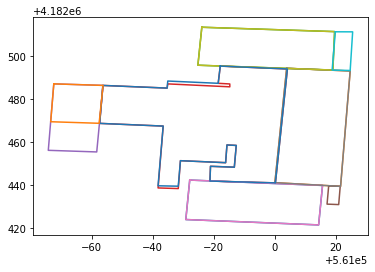

In [16]:
grid_search_val = 10.0
search_space = 10
iterations = 5
best_x_offset = 0.0
best_y_offset = 0.0
max_area = 0.0
for i in range(iterations):
    search_magnitude = grid_search_val * (10.0 ** -i)
    
    best_x_shift = 0
    best_y_shift = 0
    
    for x_shift in range(-search_space, search_space + 1):
        x_offset = best_x_offset + x_shift * search_magnitude
        for y_shift in range(-search_space, search_space + 1): 
            y_offset = best_y_offset + y_shift * search_magnitude
            
            error_adjust = np.array([x_offset, y_offset])
            polygon_coords, heights, ref_polygons = jp.parse_json_file(comp_file_name, offset=error_adjust)
            
            ref_series = geopandas.GeoSeries(ref_polygons)
            ref_frame = geopandas.GeoDataFrame({'geometry': ref_series})
            res_intersection = geopandas.overlay(poly_frame, ref_frame, how='intersection')
            intersect_area = sum(res_intersection.area)

            if intersect_area > max_area:
                
                max_area = intersect_area
                best_x_shift = x_shift
                best_y_shift = y_shift
                
    best_x_offset = best_x_offset + best_x_shift * search_magnitude
    best_y_offset = best_y_offset + best_y_shift * search_magnitude

print(max_area)
print([best_x_offset, best_y_offset])

error_adjust = np.array([best_x_offset, best_y_offset])
polygon_coords, heights, ref_polygons = jp.parse_json_file(comp_file_name, offset=error_adjust)

for polygon in ref_polygons:
    x,y = polygon.exterior.xy
    plt.plot(x,y);

for polygon in polygons:
    x,y = polygon.exterior.xy
    plt.plot(x,y);

In [17]:
polygon = polygons[3]
comp_poly = ref_polygons[0]
x,y = polygon.exterior.xy
poly_points = np.stack((x, y), axis=-1)

x,y = comp_poly.exterior.xy
comp_points = np.stack((x, y), axis=-1)

# ep.get_fund_mat(poly_points, comp_points)

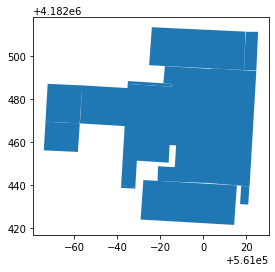

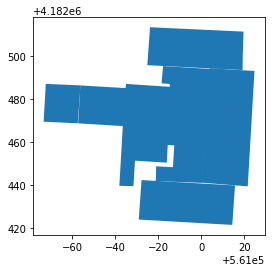

In [19]:
res_union = geopandas.overlay(poly_frame, ref_frame, how='union')
res_union.plot()

res_intersection = geopandas.overlay(poly_frame, ref_frame, how='intersection')
res_intersection.plot()

# print(res_intersection.area / res_union.area)

In [20]:
union_area = sum(res_union.area)
intersect_area = sum(res_intersection.area)

print(intersect_area / union_area)
print(intersect_area)

0.9301106898022142
5181.072125013203


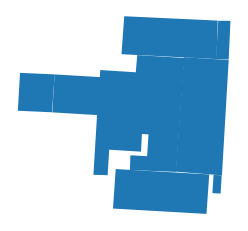

In [22]:
plot = poly_frame.plot()
plt.axis('off')
fig = plot.get_figure()
fig.savefig("polygons.png")

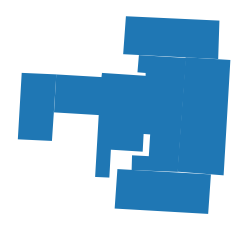

In [23]:
plot2 = ref_frame.plot()
plt.axis('off')
fig = plot2.get_figure()
fig.savefig("ref_polygons.png")

In [24]:
import cv2 
from sklearn.metrics import f1_score

y_pred = cv2.imread('polygons.png',0)
y_true = cv2.imread('ref_polygons.png', 0)

y_pred[y_pred < 255] = 1
y_pred[y_pred == 255] = 0

y_true[y_true < 255] = 1
y_true[y_true == 255] = 0

y_pred = y_pred.flatten()
y_true = y_true.flatten()

f1_score(y_true, y_pred, average='binary')

0.9502156792908307